# Embedding Layer Training Example v1

## Loading Data

In [1]:
import numpy as np
import pandas as pd 

In [2]:
#df_spells = pd.read_csv("/kaggle/input/dndspells/dnd-spells.csv")
df_spells = pd.read_csv("dataset/dnd-spells.csv")
print("Spells " + str(len(df_spells)))
df_spells[:5]

Spells 554


,name,classes,level,school,cast_time,range,duration,verbal,somatic,material,material_cost,description
0,Acid Splash,"Artificer, Sorcerer, Wizard",0,Conjuration,1 Action,60 Feet,Instantaneous,1,1,0,NaN,You hurl a bubble of acid. Choose one creature...
1,Blade Ward,"Bard, Sorcerer, Warlock, Wizard",0,Abjuration,1 Action,Self,1 round,1,1,0,NaN,You extend your hand and trace a sigil of ward...
2,Booming Blade,"Artificer, Sorcerer, Warlock, Wizard",0,Evocation,1 Action,Self (5-foot radius),1 round,0,1,1,a melee weapon worth at least 1 sp,You brandish the weapon used in the spell’s ca...
3,Chill Touch,"Sorcerer, Warlock, Wizard",0,Necromancy,1 Action,120 Feet,1 round,1,1,0,NaN,"You create a ghostly, skeletal hand in the spa..."
4,Control Flames,"Druid, Sorcerer, Wizard",0,Transmutation,1 Action,60 Feet,Instantaneous or 1 hour,0,1,0,NaN,You choose nonmagical flame that you can see w...


## Data Exploration

### Maximun number of token by row

In [3]:
!pip install spacy

In [5]:
import spacy
npl = spacy.load('en_core_web_sm')

def count_words(x):
    y = npl(x)
    return len(y)

df_spells["count_tokens"] = df_spells.apply(lambda x: count_words(x['description']),axis=1)
df_spells["count_tokens"][:5]

0     77
1     38
2    140
3    128
4    175
Name: count_tokens, dtype: int64

In [6]:
df_spells.describe()

,level,verbal,somatic,material,count_tokens
count,554.000000,554.000000,554.000000,554.000000,554.000000
mean,3.525271,0.945848,0.862816,0.523466,165.189531
std,2.470128,0.226521,0.344353,0.499900,112.745654
min,0.000000,0.000000,0.000000,0.000000,11.000000
25%,1.000000,1.000000,1.000000,0.000000,90.250000
50%,3.000000,1.000000,1.000000,1.000000,138.500000
75%,5.000000,1.000000,1.000000,1.000000,199.500000
max,9.000000,1.000000,1.000000,1.000000,800.000000


### Number of words for the vocabulary

In [8]:
!pip install tensorflow

In [9]:
import tensorflow as tf

text_vectorization_layer = tf.keras.layers.TextVectorization(
 standardize="lower_and_strip_punctuation",
 output_mode='int',
output_sequence_length=800)

In [10]:
text_vectorization_layer.adapt(df_spells['description'])

In [11]:
print("We have " + str(len(text_vectorization_layer.get_vocabulary())) + " terms as vocabulary")

We have 4504 terms as vocabulary


## Creating input X
I one_hot encode the values in the description column. Giving an integer number for each word (token). Finally, the empty space caused by the imbalanced number of tokens between rows of the column is filled with zeros.

In [12]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
vocabulary_size = 4504
df_descrip = df_spells['description']
input_x = [one_hot(d,vocabulary_size) for d in df_descrip]
max_length = 800
input_x = pad_sequences(input_x,maxlen=max_length,padding='post')
input_x[:2]

array([[1330, 1125,  951, ...,    0,    0,    0],
       [1330, 2914, 2354, ...,    0,    0,    0]])

## Creating input Y
The label (school column) is categorized in a form the model can understand. Furthermore, to avoid problems by imbalanced big values between schools, it was used 'tf.keras.utils.to_categorical' to balance it.

In [14]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

label_encoder = LabelEncoder()
label_encoder.fit(df_spells['school'])
print('Labels: ', label_encoder.classes_)

def label_encode(labels,encoder):
    encoding = encoder.transform(labels)
    return tf.keras.utils.to_categorical(encoding,len(encoder.classes_))


def label_decode(labels,decoder):
    decoding = np.argmax(labels, axis=1)
    return decoder.inverse_transform(decoding)

Labels:  ['Abjuration' 'Conjuration' 'Divination' 'Enchantment' 'Evocation'
 'Illusion' 'Necromancy' 'Transmutation']


In [15]:
input_y = label_encode(df_spells['school'],label_encoder)
input_y[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## Modeling

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Embedding,Dense

#### Important:
They are 4504 words as vocabulary. And the number max of words in a description is 800.

In [17]:
regularizer = tf.keras.regularizers.l1_l2(0, 0.001)

model = Sequential()
embedding_layer = Embedding(input_dim=4504,output_dim=64,input_length=800)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(640,kernel_regularizer=regularizer,activation='relu'))
model.add(Dense(64,kernel_regularizer=regularizer,activation='relu'))
model.add(Dense(64,kernel_regularizer=regularizer,activation='relu'))
model.add(Dense(8,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 800, 64)           288256    
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 640)               32768640  
                                                                 
 dense_1 (Dense)             (None, 64)                41024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 33,102,600
Trainable params: 33,102,600
No

In [18]:
history = model.fit(input_x,input_y,batch_size=32, epochs=15,verbose=0,validation_split=0.2, shuffle=True)

In [19]:
print(embedding_layer.get_weights()[0].shape)

(4504, 64)


In [20]:
embedding_layer.get_weights()[:20]

[array([[-0.00020558,  0.01237731,  0.04141042, ..., -0.00803448,
          0.00209095, -0.00028219],
        [ 0.05879499,  0.05261182,  0.1042459 , ..., -0.0257775 ,
         -0.0837893 ,  0.03936221],
        [-0.0406212 , -0.00304245,  0.00863783, ...,  0.06684397,
         -0.02026561, -0.04011687],
        ...,
        [ 0.03158468, -0.01215968, -0.02363378, ..., -0.02072058,
          0.04180468, -0.08524968],
        [ 0.03932232, -0.01338279,  0.03604319, ..., -0.01893971,
          0.0131509 , -0.01841431],
        [ 0.03899323, -0.00772778,  0.00949009, ...,  0.07815803,
         -0.04354057, -0.02229745]], dtype=float32)]

## Visualization

In [21]:
import matplotlib.pyplot as plt

def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric])
        ax[idx].legend([metric, 'val_' + metric])

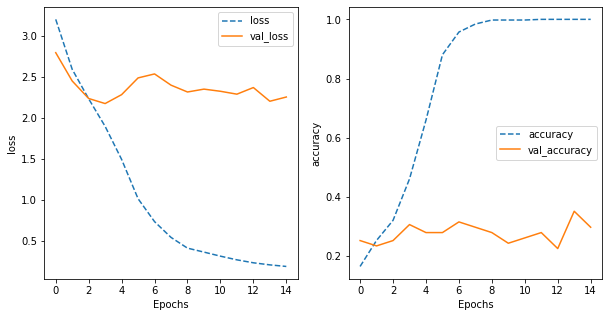

In [22]:
training_plot(['loss', 'accuracy'], history)

## Some thoughts

Obviosly it needs some improving. However, the objective was to create a basic example of how to train a embedded layer to be used later. Using transfer learning to transfer the layer toward a new model.